In [2]:
import sys
sys.path.append("../")

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from tqdm import *
import torch
from torch import nn

from utils.utils import ring2nest
from utils import create_mask as cm
from utils.psf_correction import PSFCorrection
from utils.templates import get_NFW2_template
from models.embedding import SphericalGraphCNN
from utils.plotting import make_plot, make_signal_injection_plot
from models.scd import dnds
from models.psf import KingPSF
from simulations.wrapper import simulator

from sbi import utils
from sbi import inference
from sbi.inference import PosteriorEstimator
from sbi import utils
from sbi import inference

%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

/Users/smsharma/anaconda3/lib/python3.8/site-packages/PyGSP-0.5.1-py3.8.egg/pygsp/filters/simpletight.py:76: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/smsharma/anaconda3/lib/python3.8/site-packages/PyGSP-0.5.1-py3.8.egg/pygsp/filters/simpletight.py:79: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/smsharma/anaconda3/lib/python3.8/site-packages/PyGSP-0.5.1-py3.8.egg/pygsp/filters/simpletight.py:76: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/smsharma/anaconda3/lib/python3.8/site-packages/PyGSP-0.5.1-py3.8.egg/pygsp/filters/simpletight.py:79: SyntaxWarning: "is" with a literal. Did you mean "=="?


PyTorch Geometric not importable


In [3]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Preliminaries

In [5]:
nside_list = [128, 64, 32, 16, 8, 4, 2]

In [6]:
hp_mask_nside1 = cm.make_mask_total(nside=1, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = 25)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.reorder(hp.ud_grade(hp_mask_nside1, nside), r2n=True)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])

hp_mask_nside1 = hp.reorder(hp_mask_nside1, r2n=True)

In [7]:
hp_mask_nside1_ring = cm.make_mask_total(nside=1, band_mask = True, band_mask_range = 0, mask_ring = True, inner = 0, outer = 25)
roi_sim_ring = hp.ud_grade(hp_mask_nside1_ring, 128)

In [8]:
ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
hp_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2,
                              mask_ring = True, inner = 0, outer = 25, custom_mask=ps_mask)
hp_mask = hp.reorder(hp_mask, r2n=True)
hp_mask

array([ True,  True,  True, ...,  True,  True,  True])

In [9]:
device = "cpu"

In [10]:
kp = KingPSF()

pc_inst = PSFCorrection(delay_compute=True)
pc_inst.psf_r_func = lambda r: kp.psf_fermi_r(r)

In [11]:
# Load templates
temp_gce = np.load("../data/fermi_data/template_gce.npy")
fermi_exp_ring = np.load("../data/fermi_data/fermidata_exposure.npy")

# Rescaling factor to remove exposure from PS templates
rescale = fermi_exp_ring / np.mean(fermi_exp_ring)

roi_normalize_temps = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=30)
temp_gce = get_NFW2_template(gamma=1.2, exp_map=fermi_exp_ring, roi_normalize=roi_normalize_temps)

# NEST ordering
fermi_exp = hp.reorder(np.load("../data/fermi_data/fermidata_exposure.npy"), r2n=True)

# Load templates
temp_dif = np.load("../data/fermi_data/template_dif.npy")
temp_psc = np.load("../data/fermi_data/template_psc.npy")
temp_iso = np.load("../data/fermi_data/template_iso.npy")
temp_dsk_thk = np.load("../data/fermi_data/template_dsk.npy")
temp_dsk = np.load("../data/external/template_disk_r_s_5_z_s_0.3.npy")
temp_bub = np.load("../data/fermi_data/template_bub.npy")

temp_mO_pibrem = np.load('../data/fermi_data/ModelO_r25_q1_pibrem.npy')
temp_mO_ics = np.load('../data/fermi_data/ModelO_r25_q1_ics.npy')

# temp_mA_pibrem = hp.ud_grade(np.load('../data/modelA/modelA_brempi0.npy'), nside_out=128, power=-2)
# temp_mA_ics = hp.ud_grade(np.load('../data/modelA/modelA_ics.npy'), nside_out=128, power=-2)

# temp_mA_pibrem /= np.mean(temp_mA_pibrem[~roi_normalize_temps] )
# temp_mA_ics /= np.mean(temp_mA_ics[~roi_normalize_temps] )

ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")

# Mask defining analysis ROI
roi_mask = hp.reorder(cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25, custom_mask=ps_mask), r2n=True)

# ROI over which results are normalized
roi_mask_norm = hp.reorder(cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25), r2n=True)

# ROI ove which simulations are created (nside=1 central pixel)
roi_sim = masks_list[0]

## Signal injection routines

In [12]:
def get_signal_injection(coeff, plot_map=False, mask=hp_mask):
    """ Generate DM signal injection maps
    """
    in_map = hp.reorder(np.load("../data/fermi_data/fermidata_counts.npy") + coeff * np.random.poisson(temp_gce), r2n=True)
    in_map[mask] = 0
    
    if plot_map:
        hp.mollview(in_map, max=100, nest=True)

    in_map = torch.Tensor(in_map[~masks_list[0]])
    in_map = in_map.reshape((1, -1, 1))

    log_mean = torch.log(torch.mean(in_map))
    log_std = torch.log(torch.var(in_map).sqrt())

    log_mean = log_mean.reshape((1, -1, 1))
    log_std = log_std.reshape((1, -1, 1))

    data_map = torch.cat([in_map, log_mean, log_std], axis=1)[:, :, 0]
    
    return data_map

def get_signal_injection_ps(coeff, plot_map=False, mask=hp_mask, ps="medium"):
    """ Generate PS signal injection maps
    """
    in_map = hp.reorder(np.load("../data/fermi_data/fermidata_counts.npy"), r2n=True)
    in_map[mask] = 0
    
    if ps == "bright":
        sb1 = 20.
    elif ps == "medium":
        sb1 = 10.
    elif ps == "dim":
        sb1 = 5.
    
    if coeff != 0.:
        
        prior_ps = [[0, coeff * 1., 20.0, 1.6, -5.0, sb1, 2.], [0, coeff * 1., 20.0, 1.6, -5.0, sb1, 2.]]
        prior_ps = utils.BoxUniform(low=torch.tensor(prior_ps[0]), high=torch.tensor(prior_ps[1]))
        theta = prior_ps.sample((1,))[0]
        temps_ps_sim = [temp_gce]
        temps_poiss_sim = [temp_gce]
        
        ps_map = simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, hp.reorder(masks_list[0], n2r=True)
                      , hp.reorder(roi_mask_norm, n2r=True), hp.reorder(roi_mask, n2r=True), pc_inst.psf_r_func, fermi_exp)[0]
        
        ps_map = ring2nest(ps_map, roi_sim_ring)
    
    else:
        ps_map = np.zeros((~masks_list[0]).sum())
    
    if plot_map:
        hp.mollview(in_map, max=100, nest=True)
    
    in_map = in_map[~masks_list[0]]
    in_map += ps_map[0]
    
    in_map = torch.Tensor(in_map)
    
    in_map = in_map.reshape((1, -1, 1))

    log_mean = torch.log(torch.mean(in_map))
    log_std = torch.log(torch.var(in_map).sqrt())

    log_mean = log_mean.reshape((1, -1, 1))
    log_std = log_std.reshape((1, -1, 1))

    data_map = torch.cat([in_map, log_mean, log_std], axis=1)[:, :, 0]
    
    return data_map

## Load trained estimator

In [13]:
# Test embedding net
sg_embed = SphericalGraphCNN(nside_list, indexes_list, n_aux=2, fc_dims=None).to(device)
sg_embed(get_signal_injection(0.).unsqueeze(0),).shape

torch.Size([1, 258])

In [14]:
# iso, bub, psc, dif_pibrem, dif_ics
prior_poiss = [[0.001, 0.001, 0.001, 6., 0.001], [1.5, 1.5, 1.5, 12., 5.]]

# gce, dsk
prior_ps = [[0.001, 10.0, 1.1, -10.0, 5.0, 0.1, 0.001, 10.0, 1.1, -10.0, 5.0, 0.1], [2.5, 20.0, 1.99, 1.99, 40.0, 4.99, 2.5, 20.0, 1.99, 1.99, 40.0, 4.99]]

# Combine priors
prior = utils.BoxUniform(low=torch.tensor([0.001] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([2.5] + prior_poiss[1] + prior_ps[1]))

In [15]:
# instantiate the neural density estimator
neural_classifier = utils.posterior_nn(model='maf',
                                      embedding_net=sg_embed,
                                      hidden_features=50,
                                      num_transforms=4,
)

# setup the inference procedure
inference_inst = PosteriorEstimator(prior=prior, density_estimator=neural_classifier, 
                           show_progress_bars=True,
                           logging_level='INFO',
                           device=device)

In [16]:
poiss_labels = [r"Iso", r"Bub", r"3FGL", r"$\pi^0$/brem", r"ICS"]
ps_labels = [r"GCE PS", r"Disk PS"]
temps_poiss = hp.reorder([temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics], r2n=True)
temps_ps = hp.reorder([temp_gce / rescale , temp_dsk / rescale ], r2n=True)

In [17]:
temps_poiss_sim = hp.reorder(([temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]), r2n=True)
temps_ps_sim = hp.reorder(([temp_gce / rescale, temp_dsk / rescale]), r2n=True)

temps_dict = {'fermi_exp':fermi_exp,
 'temps_ps':temps_ps,
 'temps_ps_sim':temps_ps_sim,
 'ps_labels':ps_labels,
 'temps_poiss':temps_poiss,
 'temps_poiss_sim':temps_poiss_sim,
 'poiss_labels':poiss_labels}

In [18]:
roi_normalize = hp.reorder(cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2, mask_ring = True, inner = 0, outer = 25), r2n=True)

In [19]:
from sbi.utils import x_shape_from_simulation

In [20]:
from pytorch_lightning.loggers import TensorBoardLogger, MLFlowLogger
import mlflow

run_id = '2b52bb386e3a42d691c9c9a8f3c5dfc4'
density_estimator = mlflow.pytorch.load_model('../data/logs/mlruns/12/' + run_id + '/artifacts/density_estimator')

2022/01/16 16:03:58 WARNING mlflow.pytorch: Stored model version '1.8.1' does not match installed PyTorch version '1.10.0'


### Analysis on data

In [21]:
r_outer = 25  # ROI outer radius fixed in baseline analysis

In [22]:
roi_mask_reduced = hp.reorder(cm.make_mask_total(nside=128, band_mask=True, band_mask_range=2, mask_ring=True, inner=0, 
                                                 outer=r_outer, custom_mask=ps_mask), r2n=True)

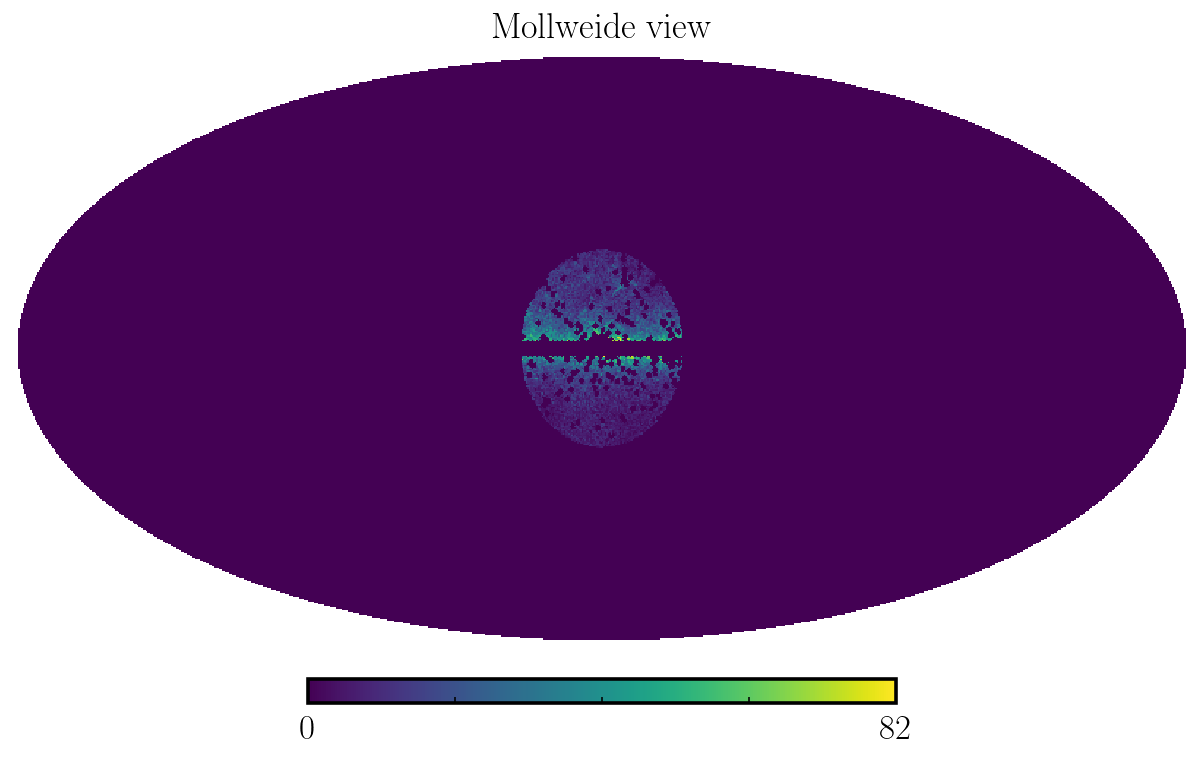

In [23]:
coeff_ary = [0.]
x_test = torch.Tensor(np.array([get_signal_injection(coeff, mask=hp_mask).detach().numpy() for coeff in coeff_ary]))

data_map = x_test[:, 0, :-2]
aux = x_test[:, :, -2:]

### For reducing ROI size. Does not do anything for baseline analysis.

indices_mask_reduced = np.intersect1d(np.where(~masks_list[0] == 1), np.where(~roi_mask_reduced == 1), return_indices=True)[1]

a = indices_mask_reduced
b = np.arange(np.sum(~masks_list[0] == 1))
c = torch.Tensor(np.setdiff1d(np.union1d(a, b), np.intersect1d(a, b))).type(torch.int64)

data_map[:, c] = 0.

### 

the_map = np.zeros(hp.nside2npix(128))
the_map[~masks_list[0]] = data_map[0]

hp.mollview(the_map, nest=True)

In [24]:
n_samples = 10000


Removed no burn in
$7.8^{+0.2}_{-0.6}$ & $37.4^{+8.9}_{-19.3}$ & $1.3^{+0.3}_{-0.4}$ & $5.0^{+0.4}_{-1.2}$ & $2.2^{+0.2}_{-0.5}$
Removed no burn in
$7.7^{+0.2}_{-0.6}$ & $55.0^{+8.8}_{-22.9}$ & $1.1^{+0.2}_{-0.2}$ & $5.4^{+0.5}_{-1.1}$ & $2.0^{+0.2}_{-0.5}$


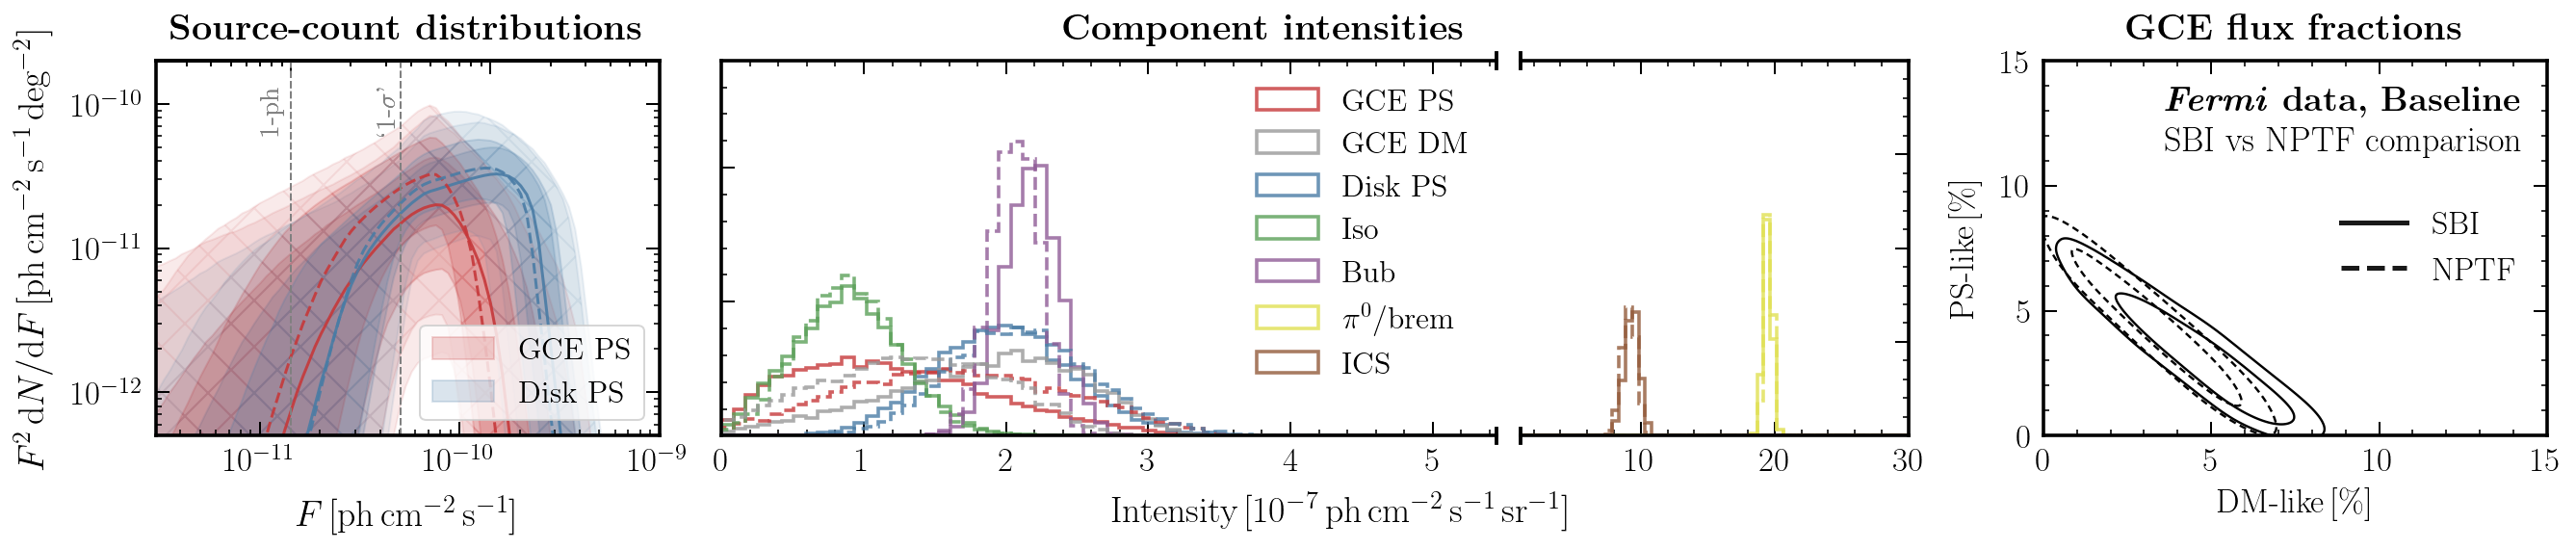

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

In [32]:
x_presimulated = torch.Tensor(data_map).unsqueeze(1)
x_aux_presimulated = torch.Tensor(aux)

posterior = inference_inst.build_posterior(prior, density_estimator)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)

fig, ax = make_plot(posterior=posterior, x_test=x_test, theta_test=None, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, is_data=True, \
          signal_injection=True, figsize=(24 / 1.3, 5 / 1.3), save_filename=None, n_samples=n_samples, temps_dict=temps_dict, sub1=r"\bf{\emph{Fermi} data, Baseline}", sub2=r"SBI vs NPTF comparison", return_ax=True)

coeff_ary = [0.]

samples_weighted = torch.Tensor(np.load("../data/nptfit_samples/fermi_data_thin_disk_1000_-1_samples.npz")["samples_weighted"])
samples_weighted = torch.unsqueeze(samples_weighted, 0).detach().numpy()

fermi_data = torch.Tensor(np.array([get_signal_injection(coeff).detach().numpy()[:,:-2] for coeff in coeff_ary]))

roi_counts_normalize = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2, mask_ring = True, inner = 0, outer = 25)

fermi_data = fermi_data.detach().numpy()

make_plot(posterior=samples_weighted, x_test=fermi_data, x_data_test=fermi_data, theta_test=None, roi_sim=roi_sim, \
          roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, is_data=True, signal_injection=False, figsize=(24 / 1.3, 5 / 1.3), nptf=True, 
          save_filename="figures/data_sbi_nptf_comparison.pdf", temps_dict=temps_dict, show_legend=False, ax_reuse=(fig, ax), second_plot=True)

In [34]:
for idx in range(2):

    data_map = ring2nest(np.load("../data/samples/x_ModelO_PS_only.npy")[idx:idx + 1, 0, :], roi_sim_ring)
    aux = np.load("../data/samples/x_aux_ModelO_PS_only.npy")[idx:idx + 1]
    thetas = np.load("../data/samples/theta_ModelO_PS_only.npy")[idx:idx + 1]

    x_presimulated = torch.Tensor(data_map).unsqueeze(1)
    x_aux_presimulated = torch.Tensor(aux)
    theta_presimulated = (thetas)

    inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
    posterior = inference_inst.build_posterior(prior, density_estimator)

    x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
    theta_test = theta_presimulated

    fig, ax = make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test, roi_sim=roi_sim, \
              roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, figsize=(24 / 1.3, 5. / 1.3), n_samples=n_samples, \
              temps_dict=temps_dict, save_filename=None, sub1=r"\bf{Simulation, only GCE PS}", sub2=r"SBI vs NPTF comparison", return_ax=True) 

    coeff_ary = [0.]

    samples_weighted = torch.Tensor(np.load("../data/nptfit_samples/ModelO_PS_only_{}_samples.npz".format(idx))["samples_weighted"])
    samples_weighted = torch.unsqueeze(samples_weighted, 0).detach().numpy()

    fermi_data = torch.Tensor(np.array([get_signal_injection(coeff).detach().numpy()[:,:-2] for coeff in coeff_ary]))

    roi_counts_normalize = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2, mask_ring = True, inner = 0, outer = 25)

    fermi_data = fermi_data.detach().numpy()

    make_plot(posterior=samples_weighted, x_test=fermi_data, x_data_test=fermi_data, theta_test=None, roi_sim=roi_sim, \
              roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, is_data=True, signal_injection=False, figsize=(24 / 1.3, 5 / 1.3), nptf=True, 
              save_filename="figures/data_sbi_nptf_comparison_ps_{}.pdf".format(idx), temps_dict=temps_dict, show_legend=False, ax_reuse=(fig, ax), second_plot=True)


Removed no burn in
$8.2^{+0.2}_{-0.6}$ & $6.2^{+2.2}_{-3.8}$ & $2.4^{+0.7}_{-1.2}$ & $4.6^{+0.4}_{-0.9}$ & $2.5^{+0.2}_{-0.5}$
Removed no burn in
$7.2^{+0.2}_{-0.4}$ & $4.9^{+1.8}_{-3.0}$ & $3.9^{+1.0}_{-2.1}$ & $5.2^{+0.4}_{-0.9}$ & $2.3^{+0.2}_{-0.5}$



Removed no burn in
$8.4^{+0.2}_{-0.6}$ & $13.3^{+4.5}_{-7.4}$ & $2.4^{+0.6}_{-1.1}$ & $4.5^{+0.4}_{-1.0}$ & $2.4^{+0.3}_{-0.6}$
Removed no burn in
$7.8^{+0.2}_{-0.5}$ & $19.1^{+4.9}_{-9.9}$ & $2.5^{+0.6}_{-1.1}$ & $4.7^{+0.4}_{-1.0}$ & $2.5^{+0.2}_{-0.6}$



Removed no burn in
$8.7^{+0.2}_{-0.6}$ & $11.2^{+3.6}_{-6.5}$ & $2.3^{+0.6}_{-1.0}$ & $4.4^{+0.4}_{-0.9}$ & $2.7^{+0.2}_{-0.5}$
Removed no burn in
$7.7^{+0.2}_{-0.5}$ & $10.8^{+3.5}_{-6.4}$ & $2.6^{+0.5}_{-1.0}$ & $5.1^{+0.3}_{-0.9}$ & $2.6^{+0.2}_{-0.4}$


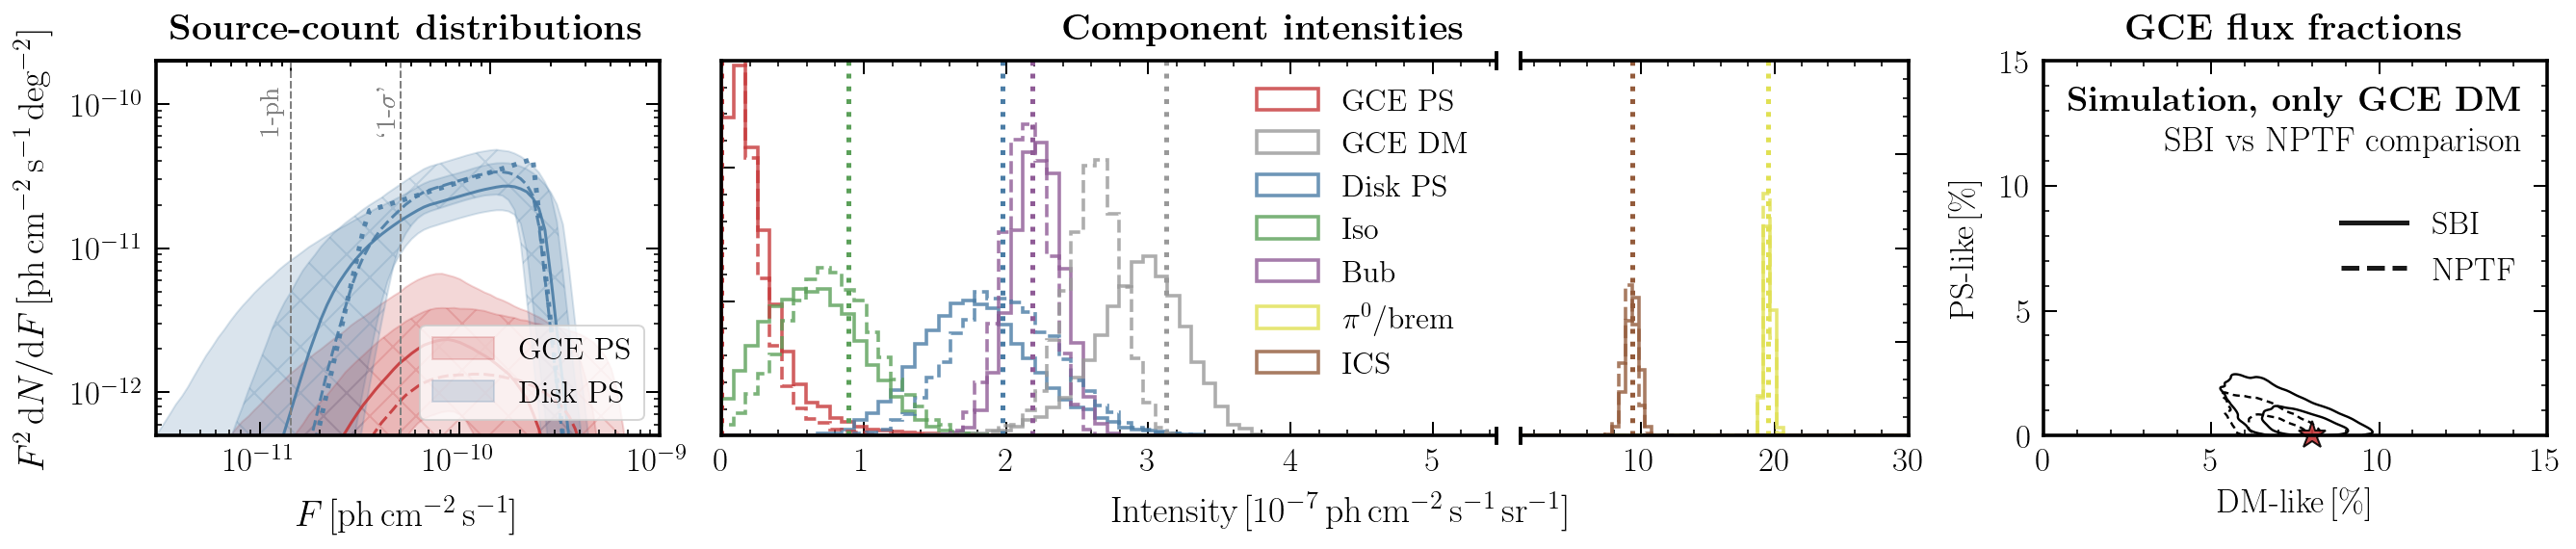

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

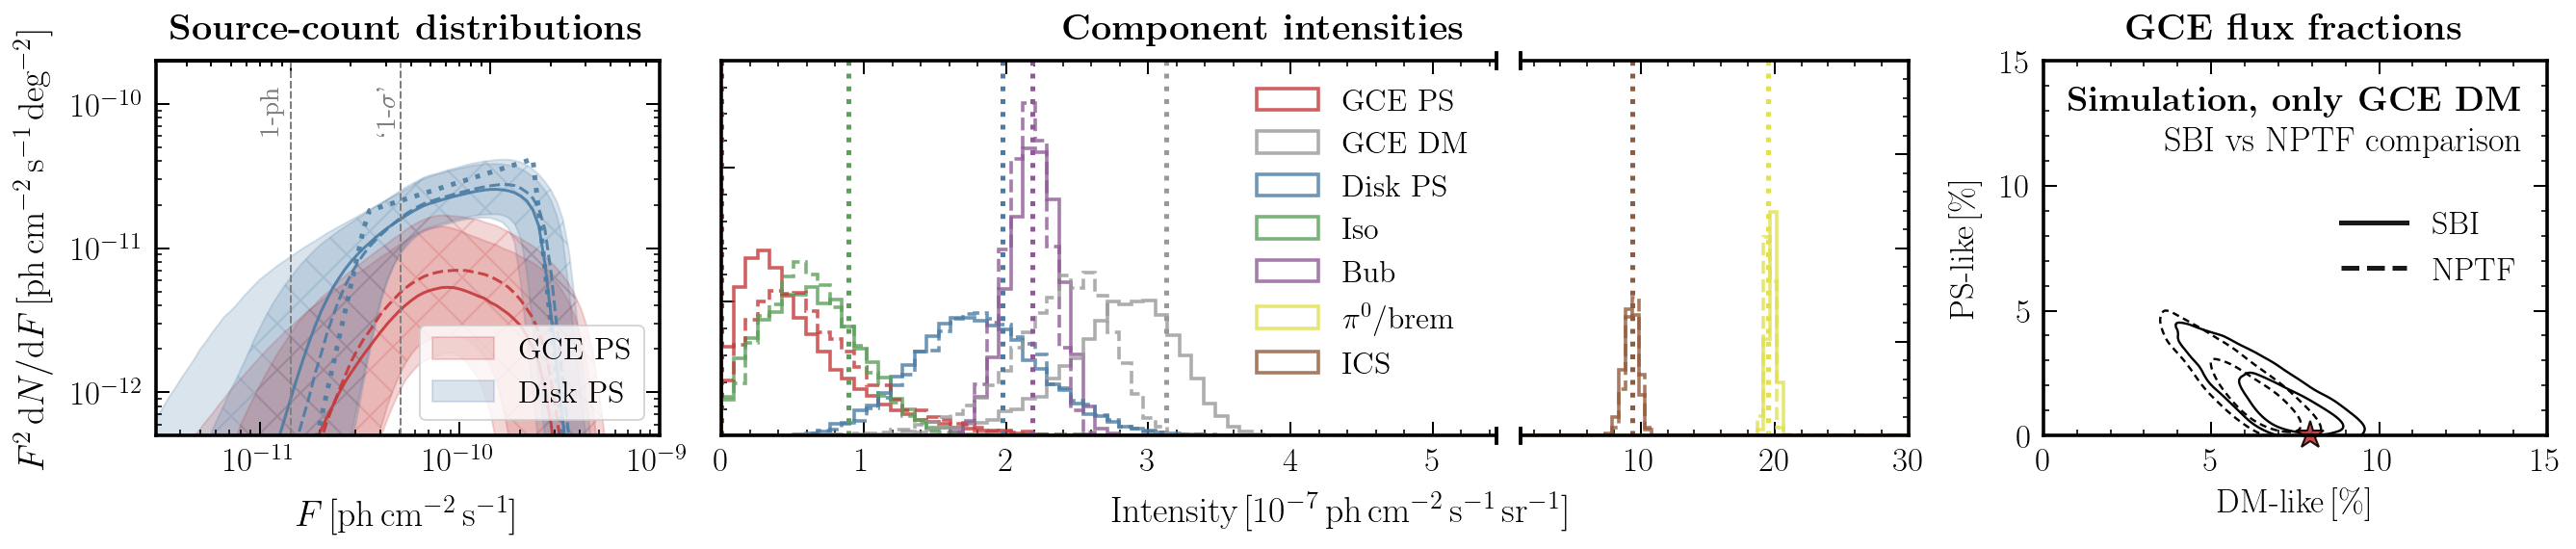

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

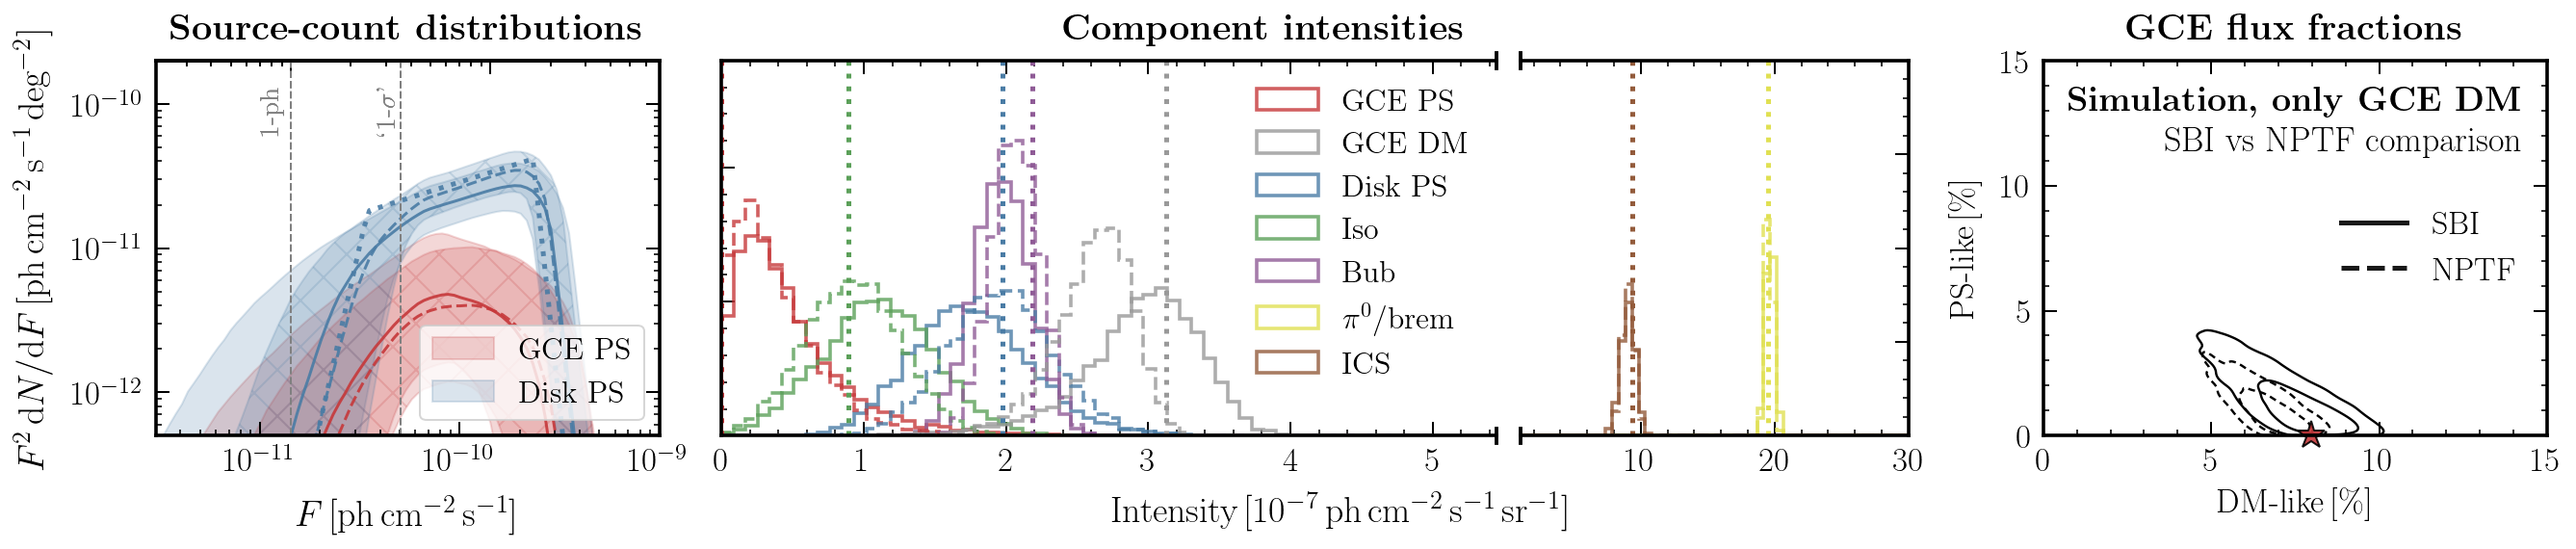

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

In [36]:
for idx in range(2,5):

    data_map = ring2nest(np.load("../data/samples/x_ModelO_DM_only.npy")[idx:idx + 1, 0, :], roi_sim_ring)
    aux = np.load("../data/samples/x_aux_ModelO_DM_only.npy")[idx:idx + 1]
    thetas = np.load("../data/samples/theta_ModelO_DM_only.npy")[idx:idx + 1]

    x_presimulated = torch.Tensor(data_map).unsqueeze(1)
    x_aux_presimulated = torch.Tensor(aux)
    theta_presimulated = (thetas)

    inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
    posterior = inference_inst.build_posterior(prior, density_estimator)

    x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
    theta_test = theta_presimulated

    fig, ax = make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test, roi_sim=roi_sim, \
              roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, figsize=(24 / 1.3, 5. / 1.3), n_samples=n_samples, \
              temps_dict=temps_dict, save_filename=None, sub1=r"\bf{Simulation, only GCE DM}", sub2=r"SBI vs NPTF comparison", return_ax=True) 

    coeff_ary = [0.]

    samples_weighted = torch.Tensor(np.load("../data/nptfit_samples/ModelO_DM_only_{}_samples.npz".format(idx))["samples_weighted"])
    samples_weighted = torch.unsqueeze(samples_weighted, 0).detach().numpy()

    fermi_data = torch.Tensor(np.array([get_signal_injection(coeff).detach().numpy()[:,:-2] for coeff in coeff_ary]))

    roi_counts_normalize = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2, mask_ring = True, inner = 0, outer = 25)

    fermi_data = fermi_data.detach().numpy()

    make_plot(posterior=samples_weighted, x_test=fermi_data, x_data_test=fermi_data, theta_test=None, roi_sim=roi_sim, \
              roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, is_data=True, signal_injection=False, figsize=(24 / 1.3, 5 / 1.3), nptf=True, 
              save_filename="figures/data_sbi_nptf_comparison_dm_{}.pdf".format(idx), temps_dict=temps_dict, show_legend=False, ax_reuse=(fig, ax), second_plot=True)